# Оценка результатов A/B-теста

###### Краткое описание проекта

Необходимо провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

###### Цели исследования

<p> 1. Оценить корректность проведения теста: </p>
<p> 1.1 проверить пересечение тестовой аудитории с конкурирующим тестом; </p>
<p> 1.2 проверить совпадение теста и маркетинговых событий, другие проблемы временных границ теста. </p>
<p> 2. Проанализировать результаты теста. </p>

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth

In [2]:
ab_project_marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')

In [3]:
ab_project_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [5]:
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

In [6]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [7]:
ab_project_marketing_events.duplicated().sum()

0

In [8]:
final_ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')

In [9]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [10]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [11]:
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [12]:
final_ab_new_users.duplicated().sum()

0

In [13]:
final_ab_events = pd.read_csv('/datasets/final_ab_events.csv')

In [14]:
final_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [15]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [16]:
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [17]:
final_ab_events.duplicated().sum()

0

In [18]:
final_ab_events[final_ab_events['details'].isna()==False]['event_name'].unique()

array(['purchase'], dtype=object)

In [19]:
final_ab_events[final_ab_events['details'].isna()]['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

Пропуски в колонке details оставляем как "полезные" - счиатем, что доп. информация есть только для ивента purchaseю

In [20]:
final_ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')

In [21]:
final_ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [22]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [23]:
final_ab_participants.duplicated().sum()

0

### Вывод

Загрузили данные, привели к нужным типам, проверили на дубликаты и пропуски.

## Оценка корректности проведения теста

Проверим на соответствие ТЗ

In [24]:
final_ab_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [25]:
final_ab_participants.groupby('ab_test').count().reset_index()

,ab_test,user_id,group
0,interface_eu_test,11567,11567
1,recommender_system_test,6701,6701


Нас интересует только recommender_system_test, поэтому оставим только их

In [26]:
final_ab_participants = final_ab_participants[final_ab_participants['ab_test']=='recommender_system_test']

In [27]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6701 entries, 0 to 6700
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  6701 non-null   object
 1   group    6701 non-null   object
 2   ab_test  6701 non-null   object
dtypes: object(3)
memory usage: 209.4+ KB


In [28]:
final_ab_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Согласно ТЗ, набор новых пользователей должен быть в период с 2020-12-07 по 2020-12-21. Проверим даты регистрации пользователей, участвующих в тесте.

In [29]:
users_dates = final_ab_participants.merge(final_ab_new_users,on='user_id',how='left')

In [30]:
users_dates['first_date'].min()

Timestamp('2020-12-07 00:00:00')

In [31]:
users_dates['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [32]:
final_ab_events.event_dt.min()

Timestamp('2020-12-07 00:00:33')

In [33]:
final_ab_events.event_dt.max()

Timestamp('2020-12-30 23:36:33')

Тест был остановлен раньше на 5 дней, чем требовалось по ТЗ. Т.к. тест предполагает улучшение метрик за 14 дней, это может повлиять на результаты теста. Для пользователей, зарегистрированных в период 17.12 - 21.12, не будет данных за полные 14 дней.

Проверим распределение по регионам учатсников, попавших в нужный нам тест

In [34]:
final_ab_participants_w_reg = final_ab_participants.merge(final_ab_new_users, on='user_id', how='left')

In [35]:
final_ab_participants_w_reg.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


In [36]:
gr1 = final_ab_participants_w_reg.groupby('region').agg({'user_id':'nunique'}).reset_index()

In [37]:
gr1 = gr1.rename(columns={'user_id':'users_count_in_ab_test'})

In [38]:
gr1

,region,users_count_in_ab_test
0,APAC,72
1,CIS,55
2,EU,6351
3,N.America,223


In [39]:
gr2 = final_ab_new_users.groupby('region').agg({'user_id':'nunique'}).reset_index()

In [40]:
gr2 = gr2.rename(columns={'user_id':'all_users_count'})

In [41]:
gr2

,region,all_users_count
0,APAC,3153
1,CIS,3155
2,EU,46270
3,N.America,9155


In [42]:
gr_merged = gr1.merge(gr2,on='region')

In [43]:
gr_merged

,region,users_count_in_ab_test,all_users_count
0,APAC,72,3153
1,CIS,55,3155
2,EU,6351,46270
3,N.America,223,9155


In [44]:
gr_merged['%_of_all'] = 100*gr_merged['users_count_in_ab_test']/gr_merged['all_users_count']

In [45]:
gr_merged

,region,users_count_in_ab_test,all_users_count,%_of_all
0,APAC,72,3153,2.283539
1,CIS,55,3155,1.743265
2,EU,6351,46270,13.725956
3,N.America,223,9155,2.435827


Ровно 15% из EU, как по ТЗ. Идём дальше

In [46]:
gr_merged['users_count_in_ab_test'].sum()

6701

Участников в тесте 6701, по ТЗ 6000. Больше - не меньше, оставим как есть.

In [47]:
final_ab_participants.groupby('group')['user_id'].nunique()

group
A    3824
B    2877
Name: user_id, dtype: int64

In [48]:
df1 = final_ab_participants.merge(final_ab_events,on='user_id')

In [49]:
df1.user_id.nunique()

3675

Из 6701 юзеров, принимающих участие в тесте, осталось 3675. Для остальных участвующих нет записей по ивентам.

In [50]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24698 entries, 0 to 24697
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     24698 non-null  object        
 1   group       24698 non-null  object        
 2   ab_test     24698 non-null  object        
 3   event_dt    24698 non-null  datetime64[ns]
 4   event_name  24698 non-null  object        
 5   details     3331 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 1.3+ MB


In [51]:
df1 = df1.merge(final_ab_new_users, on='user_id',how='left')

In [52]:
df1['lifetime'] = (df1['event_dt'].max() - df1['first_date']).dt.days

In [53]:
df1.head()

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,23
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC,23
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC,23
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,NaN,2020-12-07,EU,PC,23
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC,23


Т.к. нас интересует конверсия за период в 14 дней - добавим колонку с разницей (лайфтайм) между регистрацией и последним ивентом и отрежем всех, у кого лайфтайм больше 14.

In [54]:
df1_14 = df1[df1['lifetime']<=14]

Проверим, что время теста не совпадает с маркетинговыми активностями.

In [55]:
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [56]:
ab_project_marketing_events[(ab_project_marketing_events['finish_dt']>='2020-12-21;') & (ab_project_marketing_events['finish_dt']<='2021-01-04')]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Время проведения теста совпадает с рождественским промо. Это может исказить результаты теста

Посмотрим как распределены пользователи по группам

In [57]:
df1_14.groupby('group')['user_id'].nunique()

group
A    1531
B     391
Name: user_id, dtype: int64

Распределение неравномерное.

In [58]:
df1_14.groupby('user_id').agg({'group':'nunique'}).reset_index().sort_values(by='group',ascending=False)

,user_id,group
0,001064FEAAB631A1,1
1441,C2025648F77BD80B,1
1289,AD5DBC5507D8D7B9,1
1288,AD10DCB9478768CA,1
1287,ACFD449FA9875692,1
...,...,...
636,576F0756184C8DB1,1
635,575525DD276A50E1,1
634,574ACBC674BC385D,1
633,57442DD4178AFE27,1


Пользователей, участвующих сразу в двух группах нет.

### Вывод

Тест был остановлен раньше на 5 дней, чем требовалось по ТЗ. 15% участвующих из региона EU. Общее количество участвующих в тесте 6701, но только для 3675 из них есть логи событий. Время проведения теста совпадает с рождественским промо, что может исказить результаты теста. Распределение пользователей по группам неравномерное.

## Исследовательский анализ данных

Посмотрим распределение количества событий на пользователя

In [59]:
df1_14

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,lifetime
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,EU,iPhone,10
9,A7A3664BD6242119,A,recommender_system_test,2020-12-21 00:40:59,product_page,NaN,2020-12-20,EU,iPhone,10
10,A7A3664BD6242119,A,recommender_system_test,2020-12-25 05:19:45,product_page,NaN,2020-12-20,EU,iPhone,10
11,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:02,login,NaN,2020-12-20,EU,iPhone,10
12,A7A3664BD6242119,A,recommender_system_test,2020-12-21 00:40:58,login,NaN,2020-12-20,EU,iPhone,10
...,...,...,...,...,...,...,...,...,...,...
24672,9D263B8EF15CF188,B,recommender_system_test,2020-12-16 15:17:29,login,NaN,2020-12-16,N.America,Mac,14
24673,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18 19:06:08,login,NaN,2020-12-18,APAC,Mac,12
24674,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-19 19:58:27,login,NaN,2020-12-18,APAC,Mac,12
24675,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-20 00:29:37,login,NaN,2020-12-18,APAC,Mac,12


In [60]:
df1_14_gr = df1_14.groupby(['user_id','group']).agg({'event_name':'count'}).reset_index()

In [61]:
df1_14_gr

,user_id,group,event_name
0,001064FEAAB631A1,B,6
1,0010A1C096941592,A,12
2,00341D8401F0F665,A,2
3,003DF44D7589BBD4,A,15
4,005E096DBD379BCF,B,4
...,...,...,...
1917,FF5A1CD38F5DD996,A,10
1918,FF5B24BCE4387F86,A,9
1919,FF825C1D791989B5,A,8
1920,FF8CF7057415EB29,B,4


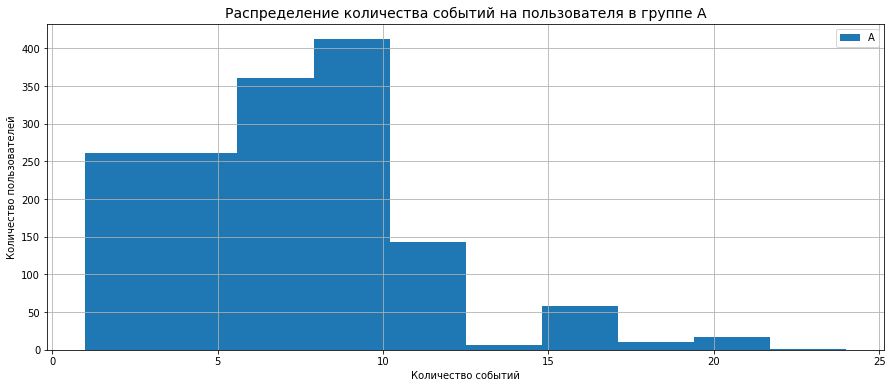

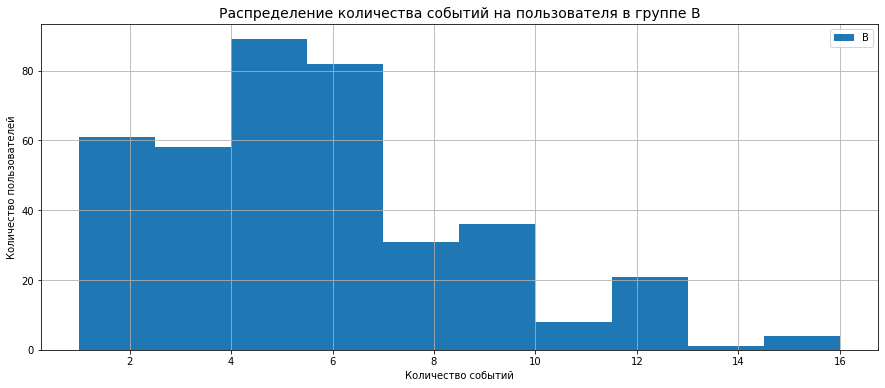

In [62]:
df1_14_gr[df1_14_gr['group']=='A'].plot(kind='hist', x='user_id', y='event_name', grid=True, label='A',figsize=(15,6))
plt.title('Распределение количества событий на пользователя в группе А', fontsize=14)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
df1_14_gr[df1_14_gr['group']=='B'].plot(kind='hist', x='user_id', y='event_name', grid=True, label='B',figsize=(15,6))
plt.title('Распределение количества событий на пользователя в группе В', fontsize=14)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
None

In [63]:
df1_14_gr[df1_14_gr['group']=='A']['event_name'].median()

6.0

In [64]:
df1_14_gr[df1_14_gr['group']=='B']['event_name'].median()

4.0

Распределения похожие, но, в среднем, ивентов на пользователя в группе А больше, чем в группе В.

Посмотрим как число событий распределено по дням.

In [65]:
df1_14['event_dt_day'] = df1_14['event_dt'].dt.floor('d')

/tmp/ipykernel_93/2328382896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_14['event_dt_day'] = df1_14['event_dt'].dt.floor('d')


In [66]:
df1_14

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,lifetime,event_dt_day
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,EU,iPhone,10,2020-12-20
9,A7A3664BD6242119,A,recommender_system_test,2020-12-21 00:40:59,product_page,NaN,2020-12-20,EU,iPhone,10,2020-12-21
10,A7A3664BD6242119,A,recommender_system_test,2020-12-25 05:19:45,product_page,NaN,2020-12-20,EU,iPhone,10,2020-12-25
11,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:02,login,NaN,2020-12-20,EU,iPhone,10,2020-12-20
12,A7A3664BD6242119,A,recommender_system_test,2020-12-21 00:40:58,login,NaN,2020-12-20,EU,iPhone,10,2020-12-21
...,...,...,...,...,...,...,...,...,...,...,...
24672,9D263B8EF15CF188,B,recommender_system_test,2020-12-16 15:17:29,login,NaN,2020-12-16,N.America,Mac,14,2020-12-16
24673,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-18 19:06:08,login,NaN,2020-12-18,APAC,Mac,12,2020-12-18
24674,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-19 19:58:27,login,NaN,2020-12-18,APAC,Mac,12,2020-12-19
24675,F2FBBA33F37DEC46,A,recommender_system_test,2020-12-20 00:29:37,login,NaN,2020-12-18,APAC,Mac,12,2020-12-20


In [67]:
df1_14_gr2 = df1_14.groupby(['event_dt_day','group']).agg({'event_name':'count'}).reset_index()

In [68]:
df1_14_gr2.head()

,event_dt_day,group,event_name
0,2020-12-16,A,396
1,2020-12-16,B,239
2,2020-12-17,A,696
3,2020-12-17,B,196
4,2020-12-18,A,909


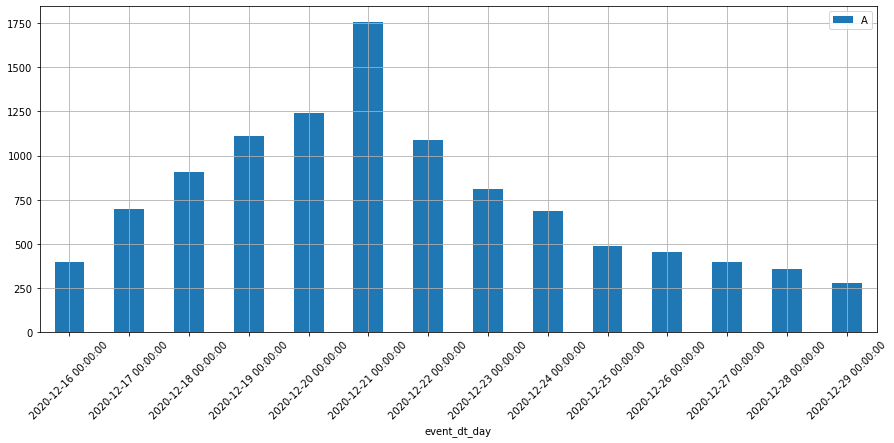

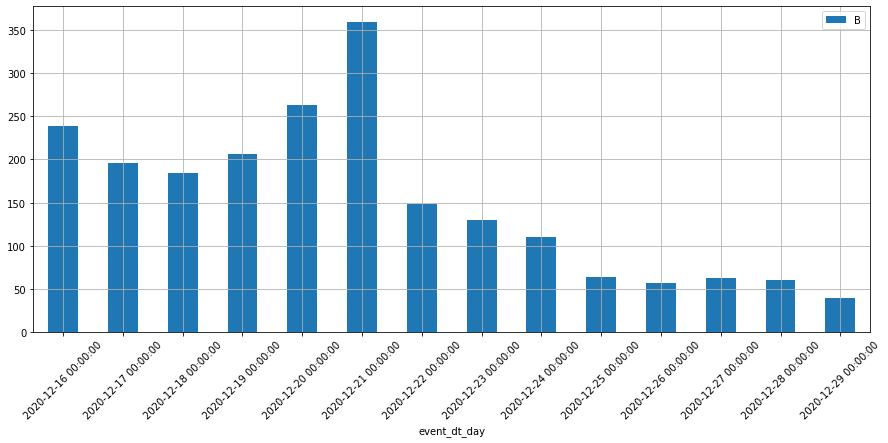

In [69]:
df1_14_gr2[df1_14_gr2['group']=='A'].plot(kind='bar', x='event_dt_day', y='event_name', grid=True, label='A',figsize=(15,6))
plt.xticks(rotation = 45)
df1_14_gr2[df1_14_gr2['group']=='B'].plot(kind='bar', x='event_dt_day', y='event_name', grid=True, label='B',figsize=(15,6))
plt.xticks(rotation = 45)
None

Пик событий приходится на 21.12.2020. Распределения похожи.

Сгруппируем по группам и посмотрим конверсии

In [70]:
df1_14_funnel = df1_14.pivot_table(index='event_name',columns='group',values='user_id',aggfunc='nunique').reset_index()

In [71]:
df1_14_funnel

group,event_name,A,B
0,login,1531,391
1,product_cart,470,120
2,product_page,1015,224
3,purchase,522,111


In [72]:
# Переопределим порядок ивентом согласно предполагаемой воронке
df1_14_funnel = df1_14_funnel.loc[[0,2,1,3],:]

In [73]:
df1_14_funnel['CR_from_login_A'] = round(100*df1_14_funnel['A']/df1_14_funnel.loc[0,'A'].sum(),2)

In [74]:
df1_14_funnel

group,event_name,A,B,CR_from_login_A
0,login,1531,391,100.0
2,product_page,1015,224,66.3
1,product_cart,470,120,30.7
3,purchase,522,111,34.1


In [75]:
df1_14_funnel['CR_from_login_B'] = round(100*df1_14_funnel['B']/df1_14_funnel.loc[0,'B'],2)

In [76]:
df1_14_funnel['CR_diff'] = round(100* (df1_14_funnel['CR_from_login_B']/df1_14_funnel['CR_from_login_A'] - 1),2)

In [77]:
df1_14_funnel

group,event_name,A,B,CR_from_login_A,CR_from_login_B,CR_diff
0,login,1531,391,100.0,100.00,0.00
2,product_page,1015,224,66.3,57.29,-13.59
1,product_cart,470,120,30.7,30.69,-0.03
3,purchase,522,111,34.1,28.39,-16.74


Конверсии каждого шага группы В хуже, чем у группы А. Так же, в группе А больше людей сконвертилось в покупку, чем в корзину.

### Вывод

Конверсии каждого шага группы В хуже, чем у группы А. Так же, в группе А больше людей сконвертилось в покупку, чем в корзину. Распределения событий по дням и распределение количества ивентов на пользователя для разных групп похожи, но для группы А, в среднем, на пользователя событий приходится чуть больше.

### Оценка результатов А/В-тестирования

Проверим стат. разницу долей конверсий на каждом шаге z-тестом

In [78]:
def ztest(alpha,event_name):
    all_users_group_1 = df1_14[df1_14['group']=='A']['user_id'].nunique()
    all_users_group_2 = df1_14[df1_14['group']=='B']['user_id'].nunique()
    event_success_users_group_1 = df1_14[(df1_14['group']=='A') & (df1_14['event_name']==event_name)]['user_id'].nunique()
    event_success_users_group_2 = df1_14[(df1_14['group']=='B') & (df1_14['event_name']==event_name)]['user_id'].nunique()
    # пропорция успехов в первой группе:
    p1 = event_success_users_group_1/all_users_group_1
    # пропорция успехов во второй группе:
    p2 = event_success_users_group_2/all_users_group_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (event_success_users_group_1 + event_success_users_group_2) / (all_users_group_1 + all_users_group_2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_users_group_1 + 1/all_users_group_2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f'Сравнение стат. значимости долей между группой A и группой B по событию {event_name}')
    print('Критический уровень статистической значимости:',alpha)
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )

In [79]:
ztest(0.05,'product_page')

Сравнение стат. значимости долей между группой A и группой B по событию product_page
Критический уровень статистической значимости: 0.05
p-значение:  0.0008958801366161229
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [80]:
ztest(0.01,'product_page')

Сравнение стат. значимости долей между группой A и группой B по событию product_page
Критический уровень статистической значимости: 0.01
p-значение:  0.0008958801366161229
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [81]:
ztest(0.05,'product_cart')

Сравнение стат. значимости долей между группой A и группой B по событию product_cart
Критический уровень статистической значимости: 0.05
p-значение:  0.9974500484667568
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [82]:
ztest(0.01,'product_cart')

Сравнение стат. значимости долей между группой A и группой B по событию product_cart
Критический уровень статистической значимости: 0.01
p-значение:  0.9974500484667568
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [83]:
ztest(0.05,'purchase')

Сравнение стат. значимости долей между группой A и группой B по событию purchase
Критический уровень статистической значимости: 0.05
p-значение:  0.03212070319187532
Отвергаем нулевую гипотезу: между долями есть значимая разница


In [84]:
ztest(0.01,'purchase')

Сравнение стат. значимости долей между группой A и группой B по событию purchase
Критический уровень статистической значимости: 0.01
p-значение:  0.03212070319187532
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Вывод

Для события product_page установлены стат. значимые различия, для product_cart стат. значимых различий не выявлено. Для purchase при уровне стат. значимости в 5% наблюдается стат. значимая разница между долями, при уровне стат. значимости в 1% - стат. значимой разницы нет.

## Общий вывод

Тест был остановлен на 5 дней раньше чем планировалось по ТЗ. Общее количество участников в тесте "recommender_system_test" составляет 6701, но только для 3675 из них есть логи событий - это нарушение требований ТЗ. Большая часть пользователей, участвующих в тесте, из региона EU. В даты проведения теста в EU была рождественская промо-акция, что могло исказить данные в поведении пользователей. Распределение пользователей по тестируемым группам неравномерное, что так же могло сказаться на результатах. По имеющимся данным, интересуемые конверсии группы В уступают группе А по каждому из шагов воронки. При проверке равенства долей конверсий в покупку z-критерием, наблюдаются разные результаты при разных уровнях значимости (при 5% разница фиксируется, при 1% - нет). На основе вышеизложенного, я бы рекоммендовал не принимать результаты данного теста и повторно его провести с соблюдением всех требований ТЗ и без пересечений с промоакциями.